In [1]:
#standard libraries
import pandas as pd
import numpy as np
from io import StringIO
import requests
from urllib.parse import urlparse, parse_qs
import matplotlib.pyplot as plt

In [2]:
def fetch_google_to_df(url):
    
    parsed_url = urlparse(url)
    spreadsheet_id = parsed_url.path.split('/')[3]  # Extract the spreadsheet ID
    query_params = parse_qs(parsed_url.query)
    gid = query_params.get('gid', ['0'])[0]  # Default to gid=0 if not present
    export_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={gid}"    


    response = requests.get(export_url)
    data = response.content
    df = pd.read_csv(StringIO(data.decode('utf-8')))   
    return df

In [3]:
Interactions = fetch_google_to_df('https://docs.google.com/spreadsheets/d/1nbn86nLAy5dOtsxPoD8CXzbeNdn892rsLUyIbXZhaXE/edit?gid=233723893#gid=233723893')
Facility_info = fetch_google_to_df('https://docs.google.com/spreadsheets/d/1nbn86nLAy5dOtsxPoD8CXzbeNdn892rsLUyIbXZhaXE/edit?gid=200201008#gid=200201008')
Personnel = fetch_google_to_df('https://docs.google.com/spreadsheets/d/1nbn86nLAy5dOtsxPoD8CXzbeNdn892rsLUyIbXZhaXE/edit?gid=942158341#gid=942158341')
Employee_lookup = fetch_google_to_df('https://docs.google.com/spreadsheets/d/1nbn86nLAy5dOtsxPoD8CXzbeNdn892rsLUyIbXZhaXE/edit?gid=1811056208#gid=1811056208')

In [5]:
import matplotlib.pyplot as plt

# Add weighted points for each boolean condition
Interactions['boolean_score'] = (
    Interactions['Diabetes'] * 40 +  # Increased weight for Diabetes
    Interactions['Hypertension'] * 50 +  # High weight for Hypertension
    Interactions['Dyslipidemia'] * 30 +  # Moderate weight
    Interactions['COVID'] * 20  # Lower weight for COVID
)

# Calculate Fever contribution
Interactions['fever_score'] = (Interactions['Fever (°F)'] - 98.6).clip(lower=0) * 10

# Calculate Blood Pressure contributions
Interactions['systolic_bp_score'] = (Interactions['BP Upper'] - 120).clip(lower=0) * 0.6  # Slightly higher impact
Interactions['diastolic_bp_score'] = (Interactions['BP Lower'] - 80).clip(lower=0) * 0.6  # Slightly higher impact

# Combine all scores
Interactions['raw_risk_score'] = (
    Interactions['boolean_score'] +
    Interactions['fever_score'] +
    Interactions['systolic_bp_score'] +
    Interactions['diastolic_bp_score']
)

# Cap the score at 100
Interactions['stroke_risk_score'] = Interactions['raw_risk_score'].clip(upper=100)

# Normalize to 0-100 range dynamically
Interactions['stroke_risk_score'] = (
    100 * Interactions['raw_risk_score'] / Interactions['raw_risk_score'].max()
)

   Diabetes  Hypertension  Dyslipidemia  COVID  Fever (°F)  BP Upper  \
0     False         False         False   True        98.3       150   
1     False         False         False   True        98.5       135   
2     False         False         False   True        98.8       115   
3     False         False         False   True        98.8       125   
4     False         False         False   True        98.5       126   

   BP Lower  stroke_risk_score  
0        94               46.4  
1        88               33.8  
2        79               22.0  
3        86               28.6  
4        81               24.2  


In [29]:
# Group by patient_age and calculate the average stroke risk score
age_avg_risk = Interactions.groupby('patient_age')['stroke_risk_score'].mean().reset_index()

# Calculate the correlation between age and average stroke risk score
correlation = age_avg_risk['patient_age'].corr(age_avg_risk['stroke_risk_score'])
correlation

# Perform linear regression to get slope and intercept
slope, intercept = np.polyfit(Interactions['patient_age'], Interactions['stroke_risk_score'], 1)

# Print the regression line equation
print(f"Stroke Risk Score Given Age = ({slope:.2f} × Age) + {intercept:.2f}")
print(f"Correlation = {round(correlation,3)}")

Stroke Risk Score Given Age = (0.03 × Age) + 29.75
Correlation = 0.286


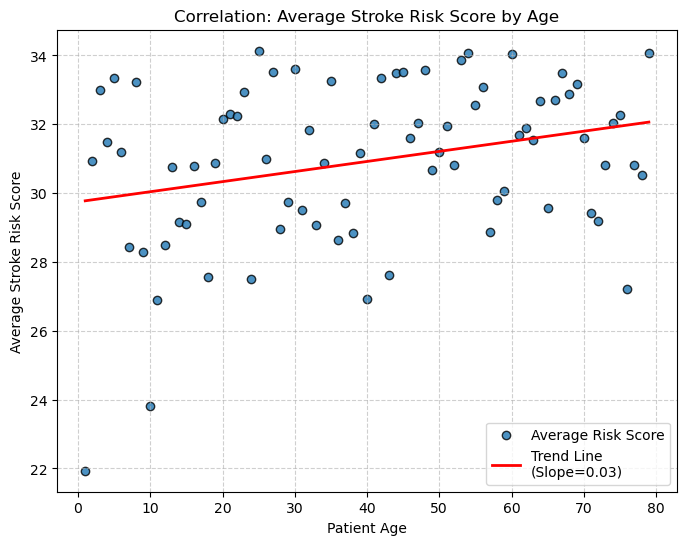

NameError: name 'correlation' is not defined